In [10]:
import xarray as xr
import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import numpy as np
import warnings
import util
warnings.filterwarnings('ignore')

from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

run="dpscream_rce_large_3km_aa_304ksst"
run_dir="/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/"
file=run_dir+f"{run}/run/{run}.eam.h1.2000-01-01-00000.nc"
print(file)
if run.split("_")[-2]=="lsascent":
    run_name = "lsascent304k"
else:
    run_name = run.split("_")[-1]
run_color=util.get_run_color(run_name)
print(run_color, run_name)

# for temp drift:
ndays=5
plt.rcParams['font.size']=18

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_aa_304ksst/run/dpscream_rce_large_3km_aa_304ksst.eam.h1.2000-01-01-00000.nc
tab:red 304ksst


# temperature drift

In [ ]:
ds = xr.open_dataset(file.replace("h1","h0"), chunks={'time':24*ndays,'lev':64,'ncol':2000})[["T","Z3"]]
t_init = ds['T'].isel(time=0).mean(dim=['ncol'])
z_init = ds.Z3.isel(time=0).mean(dim=['ncol'])/1000
t_end = ds['T'].isel(time=slice(-ndays*4,-1)).mean(dim=['ncol','time'])
z_end = ds.Z3.isel(time=-1).mean(dim=['ncol'])/1000
t_drift = t_end-t_init

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,8))
print("t_init...")
ax.plot(t_init, z_init, label="initial temp", color="lightskyblue")
print("t_end...")
ax.plot(t_end, z_end, label=f"last {ndays} days", color="b")
print("t_drift...")
axt = ax.twiny()
axt.plot(t_drift, z_end, label="temp drift", color='gray',linestyle='--')
print("done")
ax.legend()
ax.set(ylim=[0,20], xlim=[185,301], xlabel="Temperature (K)", ylabel="Height (km)")
axt.set(ylim=[0,20], xlim=[-5,5], xlabel="Temperature drift (K)")
axt.axvline(0,0,20,color='k',lw=0.5)
ax.grid(True)
plt.savefig(f"../plots/large/temp_drift_{run}_{ndays}.png")
plt.show()

# OLR and PW var over time - movie

In [ ]:
run.split("_")[-1]

In [ ]:
ds = xr.open_dataset(file, chunks={'time':200,'ncol':2000})
ndays = int((ds.time[-1]-ds.time[0]).values/1e9/3600/24)
print(ds.time[0].values, ds.time[1].values, len(ds.time),"nsteps and ", ndays,"days")
olr = ds.FLUT
pw = ds.TMQ
pw_anom = pw - pw.mean(dim=['ncol'])
pw_var = pw_anom.var(dim=['ncol']).values
x = ds.crm_grid_x/1000
y = ds.crm_grid_y/1000
days = np.linspace(0,ndays,len(ds.time))
print(x.shape, olr.shape, days.shape)
del ds, pw, pw_anom

### Movie snapshots:

In [ ]:
cmapr="cividis_r"

# do it only 60 at a time to not go over the memory limit
for t in range(1192,1201,3):  # range(len(olr.time)-2):
    print(t, end="... ")
    fig = plt.figure(figsize=plt.figaspect(0.3), layout='constrained')
    gs = GridSpec(2, 2, figure=fig, width_ratios=[100,4])
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[1,0])
    cax = fig.add_subplot(gs[0,1])
    im_olr = ax0.tripcolor(y[t,:], x[t,:], olr[t,:].T,
                           vmin=80, vmax=310, shading="gouraud", cmap=cmapr)
    ax0.set(xlabel="km",ylabel="km",title="OLR (W/m$^2$)",
            xlim=[0,5120], ylim=[0,320])
    plt.colorbar(im_olr, label="W/m$^2$", cax=cax)
    ax1.plot(days[:t], pw_var[:t], 'k')
    ax1.set(xlim=[0,50],xlabel='days',
            ylim=[0,230],ylabel='PW var')
    savename="../plots/movie/large_{}_olr_pw/olr_pwvar_{:04d}.png".format(str(run.split("_")[-1]),t) 
    plt.savefig(savename)
    print("saved as "+savename)
    plt.close()


# 2d vars over time

## SW radiation

In [ ]:
file = run_dir + run + "/run/dpscream_rce_large_3km_aa_default_h1_last5days.nc"
ds = xr.open_dataset(file, chunks={'x':2000})[['SOLIN','FSUTOA','FSUTOAC']].mean(dim=['x'])
ds = ds.where((ds.time.dt.hour>=10)&(ds.time.dt.hour<=14))
ds.SOLIN.plot.line(x="time", label="SOLIN")
ds.FSUTOA.plot.line(x="time", label="FSUT")
ds.FSUTOAC.plot.line(x="time", label="FSUTC")
plt.legend()
plt.show()
(ds.FSUTOA/ds.SOLIN).plot.line(x="time", label="albedo")
plt.legend()
plt.show()

## PW variance time series

In [2]:
runs = ["dpscream_rce_large_3km_aa_default"]
        # "dpscream_rce_large_3km_aa_304ksst",
        # "dpscream_rce_large_3km_ab_lsascent",
        # "dpscream_rce_large_3km_aa_lsascent_304ksst"]
        # "dpscream_rce_large_3km_aa_lpfrz"]
colors = ["gray","tab:red","darkviolet","tab:purple","lightcoral"]
run_dir="/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/"


2000-01-01 00:00:00 2000-01-01 01:00:00 1201 nsteps and  50 days
720 30.0
(1201, 147456) (1201,) (1201,)
saved as _default


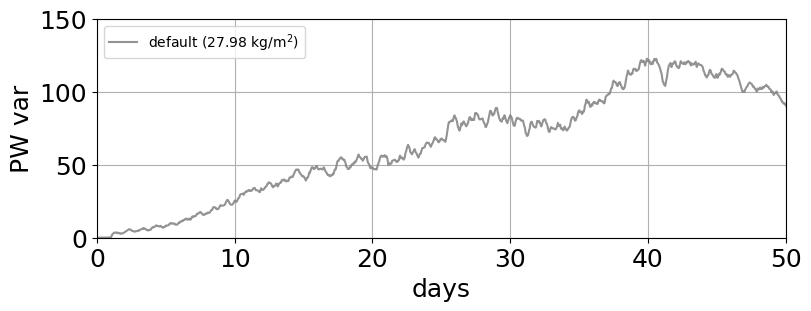

In [3]:
fig, ax1 = plt.subplots(1,1, figsize=(8,3), layout='constrained')
savename=""
for i,run in enumerate(runs):
    ls='solid'
    ds = xr.open_dataset(run_dir+f"{run}/run/{run}.eam.h1.2000-01-01-00000.nc",
                         chunks={'time':200,'ncol':2000})
    ndays = int((ds.time[-1]-ds.time[0]).values/1e9/3600/24)
    print(ds.time[0].values, ds.time[1].values, len(ds.time),"nsteps and ", ndays,"days")
    days = np.linspace(0,ndays,len(ds.time))
    n30 = np.argmin(abs(days-30))
    print(n30, days[n30])
    pw_var = ds.TMQ.var(dim=['ncol']).values
    pw_30day_mean = ds.TMQ[n30:].mean(dim=['ncol','time']).values
    x = ds.crm_grid_x/1000
    y = ds.crm_grid_y/1000
    print(x.shape, pw_var.shape, days.shape)
    del ds
    if run.split("_")[-2] == "lsascent":
        lab = "lsascent-304ksst"
    else:
        lab = run.split("_")[-1]
    savename+="_"+lab
    ax1.plot(days, pw_var, c=colors[i], linestyle=ls,
             label=f"{lab} ({pw_30day_mean:.02f} kg/m$^2$)",
             alpha=0.85)
    ax1.set(xlim=[0,50],xlabel='days',
            ylim=[0,150],ylabel='PW var')
ax1.grid()
# ax1.legend(loc="center left", fontsize=10, bbox_to_anchor=(1.,0.5))
ax1.legend(loc=2, fontsize=10)
plt.savefig(f"../plots/large/PW_var{savename}.png")
print('saved as',savename)
plt.show()

## in-situ cloud fraction

we define in-situ as NUC < BCU, NUC < BCU-2, ...


### spatial plot

In [8]:
file = run_dir + run + f"/run/{run}.eam.h0.2000-01-01-00000.nc"
nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
print(file)

ice = xr.open_dataset(file)[["IWC","T","crm_grid_x","crm_grid_y"]].isel(time=slice(-ndays*4,-1))
x = ice.crm_grid_x.isel(time=0)/1000
y = ice.crm_grid_y.isel(time=0)/1000
print(x.shape, y.shape)

nuc = xr.open_dataset(nuc_file).NUC.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
nuc = nuc.where((ice['T']<233.15)&(ice['IWC']>=1e-8))
bcu = xr.open_dataset(bcu_file).BCU.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
print(nuc.dims, bcu.dims, nuc[1].time.values, bcu[1].time.values)
nuc0 = nuc.where(nuc<(bcu-5)).count(dim=['time','lev'])
bcu0 = nuc.where(bcu<2).count(dim=['time','lev'])
nuc0 = nuc0/(nuc.shape[0]*nuc.shape[1])
bcu0 = bcu0/(nuc.shape[0]*nuc.shape[1])
# nuc0 = np.nanmean(np.where(nuc<bcu,1,0), axis=(0,1))
# bcu0 = np.nanmean(np.where(bcu<=0.125,1,0), axis=(0,1))
print(nuc.shape, nuc0.shape, bcu0.shape)  # , nuc2.shape)

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_ab_lsascent/run/dpscream_rce_large_3km_ab_lsascent.eam.h0.2000-01-01-00000.nc
(147456,) (147456,)
('time', 'lev', 'ncol') ('time', 'lev', 'ncol') 2000-02-15 12:00:00 2000-02-15 12:00:00
(19, 128, 147456) (147456,) (147456,)


saved as ../plots/large/insitu_cirrus_dc_frac_lsascent_last5days.png


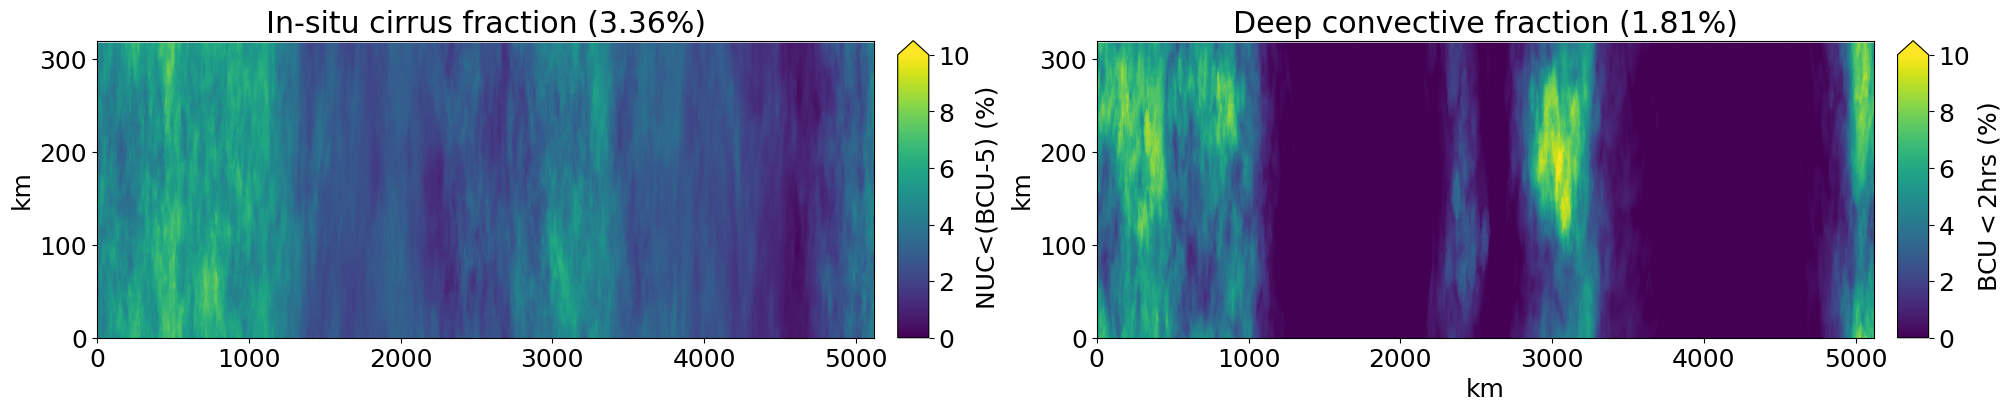

In [9]:
fig = plt.figure(figsize=(20,4), layout='constrained')
gs = GridSpec(1, 4, figure=fig, width_ratios=[100,4,100,4], hspace=0)
savename=""
if run.split("_")[-2]=="lsascent":
    lab = "lsascent304k"
else:
    lab=run.split("_")[-1]
savename+=lab

ax0 = fig.add_subplot(gs[0,0])
cax0 = fig.add_subplot(gs[0,1])
im = ax0.tripcolor(y, x, nuc0*100,
                   vmin=0, vmax=10,
                   shading="gouraud", cmap="viridis")
plt.colorbar(im, label="NUC<(BCU-5) (%)", cax=cax0, shrink=0.8, extend='max')
ax1 = fig.add_subplot(gs[0,2])
cax1 = fig.add_subplot(gs[0,3])
im = ax1.tripcolor(y, x, bcu0*100,
                   vmin=0, vmax=10,
                   shading="gouraud", cmap="viridis")
plt.colorbar(im, label="BCU$<2$hrs (%)", cax=cax1, shrink=0.8, extend='max')

ax0.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
ax1.set(xlabel="km",ylabel="km",
        xlim=[0,5120], ylim=[0,320])
ax0.set_title(f"In-situ cirrus fraction ({(np.nanmean(nuc0)*100):.02f}%)")
ax1.set_title(f"Deep convective fraction ({(np.nanmean(bcu0)*100):.02f}%)")
savename=f"../plots/large/insitu_cirrus_dc_frac_{savename}_last{ndays}days.png"
plt.savefig(savename)
print("saved as "+savename)
plt.show()

### vertical plot

In [11]:
file = run_dir + run + f"/run/{run}.eam.h0.2000-01-01-00000.nc"
nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
print(file)

ice = xr.open_dataset(file, chunks={'x':2000})[["IWC","T","Z3","crm_grid_x","crm_grid_y"]].isel(time=slice(-ndays*4,-1))
# z = xr.open_dataset(run_dir + run + f"/run/{run}_Zmean_last5days.nc").Z3[0,0,:,0]
z = ice.Z3.mean(dim=['time','ncol'])
print(z.shape)
print(ice.time[0].values, ice.time[-1].values)
nuc = xr.open_dataset(nuc_file).NUC.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
print(nuc.time[0].values, nuc.time[-1].values)
nuc = nuc.where((ice['T']<233.15)&(ice['IWC']>=1e-8))
bcu = xr.open_dataset(bcu_file).BCU.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
print(nuc.dims, bcu.dims, nuc[1].time.values, bcu[1].time.values)
nuc0 = nuc.where(nuc<(bcu-5)).count(dim=['time','ncol'])
bcu0 = bcu.where(bcu<2).count(dim=['time','ncol'])
nuc0 = nuc0/(nuc.shape[0]*nuc.shape[-1])
bcu0 = bcu0/(bcu.shape[0]*bcu.shape[-1])
# nuc0 = np.nanmean(np.where(nuc<bcu,1,0), axis=(0,2))
# bcu0 = np.nanmean(np.where(bcu<=0.125,1,0), axis=(0,2))

print(nuc.shape, nuc0.shape, bcu0.shape)  # , nuc2.shape)


/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_aa_304ksst/run/dpscream_rce_large_3km_aa_304ksst.eam.h0.2000-01-01-00000.nc
(128,)
2000-02-15 06:00:00 2000-02-19 18:00:00
2000-02-15 06:00:00 2000-02-19 18:00:00
('time', 'lev', 'ncol') ('time', 'lev', 'ncol') 2000-02-15 12:00:00 2000-02-15 12:00:00
(19, 128, 147456) (128,) (128,)


In [12]:
nuc0.values

[########################################] | 100% Completed | 5.39 ss
[########################################] | 100% Completed | 5.49 s
[########################################] | 100% Completed | 5.52 s


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.96193120e-05, 3.10529742e-04,
       1.98988887e-03, 6.85021473e-03, 1.76084641e-02, 3.98795145e-02,
       6.32616902e-02, 8.87765271e-02, 1.12083390e-01, 1.38626902e-01,
       1.57171595e-01, 1.68072974e-01, 1.64132815e-01, 1.46039282e-01,
       1.16652104e-01, 8.71325041e-02, 6.17518732e-02, 4.14339478e-02,
       2.59549325e-02, 1.57049525e-02, 9.14956255e-03, 5.36324127e-03,
       3.24914051e-03, 2.38001416e-03, 2.01594481e-03, 1.75931161e-03,
      

[########################################] | 100% Completed | 4.78 ss
[########################################] | 100% Completed | 4.88 s
[########################################] | 100% Completed | 4.89 s
[########################################] | 100% Completed | 4.59 ss
[########################################] | 100% Completed | 4.69 s
[########################################] | 100% Completed | 4.79 s
[########################################] | 100% Completed | 2.44 ss
[########################################] | 100% Completed | 2.54 s
[########################################] | 100% Completed | 2.55 s
saved as ../plots/large/insitu_cirrus_dc_vertical_304ksst_last5days.png


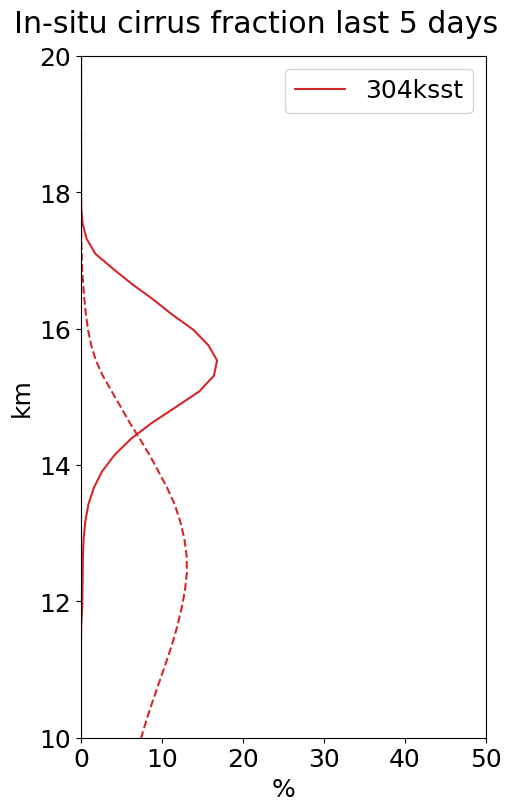

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5,8), layout='constrained')

ax.plot(nuc0*100, z/1000, color=run_color, label=run_name)
ax.plot(bcu0*100, z/1000, color=run_color, linestyle="--")
ax.set(ylabel="km", xlabel="%", xlim=[0,50], ylim=[10,20])
fig.suptitle(f"In-situ cirrus fraction last {ndays} days")
plt.legend()
savename=f"../plots/large/insitu_cirrus_dc_vertical_{run_name}_last{ndays}days.png"
plt.savefig(savename, transparent=True)
print("saved as "+savename)
plt.show()

### timeseries

In [10]:
file = run_dir + run + f"/run/{run}.eam.h0.2000-01-01-00000.nc"
nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
print(file)

chunks = {'time':100, 'ncol':16000, 'x':16000}

ice = xr.open_dataset(file, chunks=chunks)[["IWC","T","crm_grid_x","crm_grid_y"]]
x = ice.crm_grid_x.isel(time=0)/1000
y = ice.crm_grid_y.isel(time=0)/1000
print(x.shape, y.shape)

nuc = xr.open_dataset(nuc_file, chunks=chunks).NUC.rename({'x':'ncol'}) #.sel(time=ice.time, method="nearest")
nuc = nuc.where((ice['T']<233.15)&(ice['IWC']>=1e-8))
bcu = xr.open_dataset(bcu_file, chunks=chunks).BCU.rename({'x':'ncol'})# .sel(time=ice.time, method="nearest")
print(nuc.dims, bcu.dims, nuc[1].time.values, bcu[1].time.values)
nuc

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_aa_default/run/dpscream_rce_large_3km_aa_default.eam.h0.2000-01-01-00000.nc
(147456,) (147456,)
('time', 'lev', 'ncol') ('time', 'lev', 'ncol') 2000-01-01 06:00:00 2000-01-01 06:00:00


<xarray.DataArray 'NUC' (time: 201, lev: 128, ncol: 147456)> Size: 15GB
dask.array<where, shape=(201, 128, 147456), dtype=float32, chunksize=(100, 128, 16000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2kB 2000-01-01 00:00:00 ... 2000-02-20 00:00:00
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol
Attributes:
    long_name:     Nucleation tracer
    units:         kg/kg
    mdims:         1
    mixing_ratio:  dry
    cell_methods:  time: point

In [11]:
nuc0 = nuc.where(nuc<bcu).count(dim=['lev','ncol'])
bcu0 = nuc.where(bcu<2).count(dim=['lev','ncol'])
nuc0

<xarray.DataArray 'NUC' (time: 201)> Size: 2kB
dask.array<sum-aggregate, shape=(201,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2kB 2000-01-01 00:00:00 ... 2000-02-20 00:00:00

In [12]:
nuc0 = nuc0/(nuc.shape[-1]*nuc.shape[1])
bcu0 = bcu0/(nuc.shape[-1]*nuc.shape[1])
# nuc0 = np.nanmean(np.where(nuc<bcu,1,0), axis=(0,1))
# bcu0 = np.nanmean(np.where(bcu<=0.125,1,0), axis=(0,1))
print(nuc.shape, nuc0.shape, bcu0.shape)  # , nuc2.shape)
nuc0

(201, 128, 147456) (201,) (201,)


<xarray.DataArray 'NUC' (time: 201)> Size: 2kB
dask.array<truediv, shape=(201,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2kB 2000-01-01 00:00:00 ... 2000-02-20 00:00:00

In [ ]:
nuc0.compute()
bcu0.compute()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,3), layout='constrained')

nuc0.plot(x='time', ax=ax, color='tab:red', label='NUC')
bcu0.plot(x='time', ax=ax, color='tab:blue', label='BCU')

ax.legend()
ax.grid(True)
plt.show()

[########################################] | 100% Completed | 33m 41s
[###############                         ] | 38% Completed | 439.67 s

### W_NUC and NI_NUC and NI for in-situ vs convective gridboxes

In [ ]:
file = run_dir + run + f"/run/{run}.eam.h0.2000-01-01-00000.nc"
var_name="NI_NUC"
nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
var_file = run_dir + run + f"/run/{run}_{var_name}_hrs.nc"
qsmall=1e-8
print(var_name, file)

ice = xr.open_dataset(file, chunks={'x':2000})[["NUMICE","Q","IWC","T"]].isel(time=slice(-ndays*4,-1))
nuc = xr.open_dataset(nuc_file).NUC.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
bcu = xr.open_dataset(bcu_file).BCU.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
if var_name!="NI":
    var = xr.open_dataset(var_file, chunks={'x':2000})[var_name].rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
    var = var.where((ice['T']<233.15)&(ice['IWC']>qsmall))
print(nuc.dims, bcu.dims, nuc[1].time.values, bcu[1].time.values)
print(nuc.shape, bcu.shape)
# nuc = nuc.where(nuc<bcu).count(dim=['time','lev'])
# bcu = nuc.where(bcu<2).count(dim=['time','lev'])
if var_name=="NI_NUC":
    var = util.calc_ni(var, ice.Q, ice.lev, ice['T'])/1e6
elif var_name=="NI":
    var = util.calc_ni(ice.NUMICE, ice.Q, ice.lev, ice['T'])/1e6
print(var.shape)
var_insitu = var.where(nuc<bcu)
print(var_insitu.shape)
var_conv = var.where(bcu<2)
print(var_conv.shape)
print("done.")

In [ ]:
fig = plt.figure(figsize=(7,3))
if var_name=="W_NUC":
    var_conv.plot.hist(bins=[0,0.25,0.5,1,2,4,8,16], histtype='step',
                       label='convective', yscale='log', xscale='log', lw=2)
    var_insitu.plot.hist(bins=[0,0.25,0.5,1,2,4,8], histtype='step',
                         label='in-situ', yscale='log', xscale='log', lw=2)
    plt.xlabel("W_NUC (m/s)")
elif var_name=="NI_NUC":
    var_conv.plot.hist(bins=np.logspace(-6,0,30), histtype='step',
                       label='convective', yscale='log', xscale='log', lw=2)
    var_insitu.plot.hist(bins=np.logspace(-6,0,30), histtype='step',
                         label='in-situ', yscale='log', xscale='log', lw=2)
    plt.xlabel("calc ni NUC (#/cm3)")
elif var_name=="NI":
    var_conv.plot.hist(bins=np.logspace(-6,0,30), histtype='step',
                       label='convective', yscale='log', xscale='log', lw=2)
    var_insitu.plot.hist(bins=np.logspace(-6,0,30), histtype='step',
                         label='in-situ', yscale='log', xscale='log', lw=2)
    plt.xlabel("calc ni (#/cm3)")
plt.title(f"{var_name} {(run[-8:])}")  # ({(np.nanmean(var_insitu)):.02f}) m/s")
plt.legend(fontsize=12)
plt.savefig(f"../plots/large/hist_{var_name}_{run}.png")
print('saved')
plt.show()

## 2d vars snapshot - 5 panels

In [ ]:
ndays = 13
for ndays in [10,20]:
    t = 24 * ndays  # day n * 24
    t3d = 4 * ndays
    vars = ["TMQ","FLUT","LHFLX","SHFLX","PRECC","PRECL","TGCLDIWP","crm_grid_x","crm_grid_y"]
    var_units = ["kg/m2","W/m2","W/m2","W/m2","m/s","m/s"]
    
    file = run_dir + run + f"/run/{run}.eam.h1.2000-01-01-00000.nc"
    nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
    bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
    print(file)
    ds = xr.open_dataset(file, chunks={'x':2000})[vars].isel(time=t)  # .isel(time=slice(-120,-1))
    print(ds.time.values)
    
    x = ds.crm_grid_x/1000
    y = ds.crm_grid_y/1000
    
    ice = xr.open_dataset(file.replace("h1","h0"), chunks={'x':2000}).isel(time=t3d)[["IWC","T"]]
    print(ice.time.values)
    nuc = xr.open_dataset(nuc_file).NUC.isel(time=t3d).rename({'x':'ncol'})
    print(nuc.shape)
    print(nuc.dims, ice.dims)
    # nuc = nuc.where((ice['T']<233.15)&(ice['IWC']>=1e-8))
    nuc = nuc.where((ice['T']<213.15)&(ice['IWC']>=1e-8))
    print(nuc.shape)
    bcu = xr.open_dataset(bcu_file).BCU.isel(time=t3d).rename({'x':'ncol'})
    nuc0hrs = nuc.where(bcu<2).mean(dim=['lev'])
    nuc2hrs = nuc.where((bcu>=2)&(bcu<5)).mean(dim=['lev'])
    nuc5hrs = nuc.where((bcu>=5)&(bcu<50)).mean(dim=['lev'])
    nuc50hrs = nuc.where(bcu>=50).mean(dim=['lev'])
    print(nuc.shape, nuc0hrs.shape, nuc2hrs.shape, nuc5hrs.shape, nuc50hrs.shape)
    
    # do it only 60 at a time to not go over the memory limit
    # for t in range(10,110):  # range(len(olr.time)-2):
    print(t, end="... ")
    fig = plt.figure(figsize=(15,20), layout='constrained')
    gs = GridSpec(7, 2, figure=fig, width_ratios=[100,4], hspace=0)
    ax0 = fig.add_subplot(gs[0,0])
    cax0 = fig.add_subplot(gs[0,1])
    im = ax0.tripcolor(y, x, ds["TMQ"].T,
                       vmin=10, vmax=60,
                       shading="gouraud", cmap="viridis")
    plt.colorbar(im, label="PW (mm)", cax=cax0, shrink=0.8)
    ax1 = fig.add_subplot(gs[1,0])
    cax1 = fig.add_subplot(gs[1,1])
    im = ax1.tripcolor(y, x, (ds["FLUT"].T),
                       vmin=150, vmax=310,
                       shading="gouraud", cmap="cividis_r")
    plt.colorbar(im, label="OLR (W/m$^2$)", cax=cax1, shrink=0.8)
    ax2 = fig.add_subplot(gs[2,0])
    cax2 = fig.add_subplot(gs[2,1])
    im = ax2.tripcolor(y, x, (np.log10(ds["TGCLDIWP"]*1000).T),
                       vmin=-4, vmax=4,
                       shading="gouraud", cmap="YlGnBu_r")
    plt.colorbar(im, label="log10(IWP (g/m$^3$))", cax=cax2, shrink=0.8)
    ax3 = fig.add_subplot(gs[3,0])
    cax3 = fig.add_subplot(gs[3,1])
    im = ax3.tripcolor(y, x, nuc0hrs,
                       vmin=0, vmax=6,
                       shading="gouraud", cmap="gnuplot")
    plt.colorbar(im, label="NUC (hrs)",
                 cax=cax3, shrink=0.8, extend='max')
    ax4 = fig.add_subplot(gs[4,0])
    cax4 = fig.add_subplot(gs[4,1])
    im = ax4.tripcolor(y, x, nuc2hrs,
                       vmin=0, vmax=6,
                       shading="gouraud", cmap="gnuplot")
    plt.colorbar(im, label="NUC (hrs)",
                 cax=cax4, shrink=0.8, extend='max')
    ax5 = fig.add_subplot(gs[5,0])
    cax5 = fig.add_subplot(gs[5,1])
    im = ax5.tripcolor(y, x, nuc5hrs,
                       vmin=0, vmax=6,
                       shading="gouraud", cmap="gnuplot")
    plt.colorbar(im, label="NUC (hrs))",
                 cax=cax5, shrink=0.8, extend='max')
    ax6 = fig.add_subplot(gs[6,0])
    cax6 = fig.add_subplot(gs[6,1])
    im = ax6.tripcolor(y, x, nuc50hrs,
                       vmin=0, vmax=6,
                       shading="gouraud", cmap="gnuplot")
    plt.colorbar(im, label="NUC (hrs)",
                 cax=cax6, shrink=0.8, extend='max')
    
    ax0.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
    ax1.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
    ax2.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
    ax3.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
    ax4.set(xlabel="km", xlim=[0,5120], ylim=[0,320])
    ax5.set(xlabel="km", xlim=[0,5120], ylim=[0,320])
    ax6.set(xlabel="km",ylabel="km",
            xlim=[0,5120], ylim=[0,320])
    fig.suptitle(f"{ds.time.values}")
    savename=f"../plots/large/vars2d_cirrustemps_{run}_{t:03d}.png"
    plt.savefig(savename)
    print("saved as "+savename)
    plt.close()

In [ ]:

# # do it only 60 at a time to not go over the memory limit
# # for t in range(17,110):  # range(len(olr.time)-2):
# print(t, end="... ")
# fig = plt.figure(figsize=(15,20), layout='constrained')
# gs = GridSpec(6, 2, figure=fig, width_ratios=[100,4], hspace=0)
# ax0 = fig.add_subplot(gs[0,0])
# cax0 = fig.add_subplot(gs[0,1])
# im = ax0.tripcolor(y, x, ds["TMQ"].T,
#                    vmin=10, vmax=60,
#                    shading="gouraud", cmap="viridis")
# plt.colorbar(im, label="PW (mm)", cax=cax0, shrink=0.8)
# ax1 = fig.add_subplot(gs[1,0])
# cax1 = fig.add_subplot(gs[1,1])
# im = ax1.tripcolor(y, x, (ds["FLUT"].T),
#                    vmin=150, vmax=310,
#                    shading="gouraud", cmap="viridis")
# plt.colorbar(im, label="FLUT (W/m2)", cax=cax1, shrink=0.8)
# ax2 = fig.add_subplot(gs[2,0])
# cax2 = fig.add_subplot(gs[2,1])
# im = ax2.tripcolor(y, x, ((ds["LHFLX"]+ds["SHFLX"]).T),
#                    vmin=60, vmax=140,
#                    shading="gouraud", cmap="viridis")
# plt.colorbar(im, label="THF (W/m2)", cax=cax2, shrink=0.8)
# ax3 = fig.add_subplot(gs[3,0])
# cax3 = fig.add_subplot(gs[3,1])
# im = ax3.tripcolor(y, x, ((ds["PRECC"]+ds["PRECL"]).T)*(3600*24*1000),
#                    vmin=60, vmax=100,
#                    shading="gouraud", cmap="viridis")
# plt.colorbar(im, label="PREC (mm/day)", cax=cax3, shrink=0.8)
# ax4 = fig.add_subplot(gs[4,0])
# cax4 = fig.add_subplot(gs[4,1])
# im = ax4.tripcolor(y, x, (np.log10(ds["TGCLDIWP"]*1000).T),
#                    vmin=-4, vmax=4,
#                    shading="gouraud", cmap="viridis")
# plt.colorbar(im, label="log10(IWP (g/m3))", cax=cax4, shrink=0.8)
# ax5 = fig.add_subplot(gs[5,0])
# cax5 = fig.add_subplot(gs[5,1])
# im = ax5.tripcolor(y, x, nuc,
#                    vmin=0, vmax=12,
#                    shading="gouraud", cmap="terrain")
# plt.colorbar(im, label="NUC > BCU (T<-40$^\circ$C & cldy)",
#              cax=cax5, shrink=0.8, extend='max')

# ax0.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
# ax1.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
# ax2.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
# ax3.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
# ax4.set(xlabel="km", xlim=[0,5120], ylim=[0,320])
# ax5.set(xlabel="km",ylabel="km",
#         xlim=[0,5120], ylim=[0,320])
# fig.suptitle(f"{ds.time.values}")
# savename=f"../plots/large/vars2d_pw_olr_prec_thf_iwp_nuc_t{t:03d}.png"
# plt.savefig(savename)
# print("saved as "+savename)
# plt.show()
